In [1]:
from qiskit import IBMQ
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}

In [2]:
provider = IBMQ.load_account()
#change the provider based on your Qiskit account
#if you do not have access to the twenty qubit machine, use the publically available backend instead
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>,
 <IBMQBackend('ibmq_almaden') from IBMQ(hub='ibm-q-ncsu', group='nc-state

In [3]:
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
import math

#Include our assertion function
from qiskit.compiler.assertion import classical_assertion, superposition_assertion, entanglement_assertion, calcSuccessrate

In [4]:
#We used ibmq_20_tokyo for our experiment, however, that backend has retired. So we can use the publically available ibmqx2 backend instead
device = provider.get_backend('ibmqx2')
#if you have access to the twenty qubit machine, use this 20 qubit machine instead
#device = provider.get_backend('ibmq_boeblingen')
backend_monitor(device)
device

ibmq_boeblingen
Configuration
-------------
    n_qubits: 20
    operational: True
    status_msg: active
    pending_jobs: 156
    backend_version: 1.0.3
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    open_pulse: True
    n_registers: 1
    u_channel_lo: [[{'q': 1, 'scale': [1.0, 0.0]}], [{'q': 0, 'scale': [1.0, 0.0]}], [{'q': 2, 'scale': [1.0, 0.0]}], [{'q': 6, 'scale': [1.0, 0.0]}], [{'q': 1, 'scale': [1.0, 0.0]}], [{'q': 3, 'scale': [1.0, 0.0]}], [{'q': 2, 'scale': [1.0, 0.0]}], [{'q': 4, 'scale': [1.0, 0.0]}], [{'q': 8, 'scale': [1.0, 0.0]}], [{'q': 3, 'scale': [1.0, 0.0]}], [{'q': 6, 'scale': [1.0, 0.0]}], [{'q': 10, 'scale': [1.0, 0.0]}], [{'q': 1, 'scale': [1.0, 0.0]}], [{'q': 5, 'scale': [1.0, 0.0]}], [{'q': 7, 'scale': [1.0, 0.0]}], [{'q': 6, 'scale': [1.0, 0.0]}], [{'q': 8, 'scale': [1.0, 0.0]}], [{'q': 12, 'scale': [1.0, 0.0]}], [{'q': 3, 'scale': [1.0, 0.0]}], [{'q': 7, 'scale': [1.0, 0.0]}], [{'q': 9, 'scale': [1.0, 0.0]}], [{'q'

<IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-ncsu', group='nc-state', project='on-boarding')>

In [5]:
transQcList = []

pi = math.pi

In [6]:
n = 4
import numpy as np
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
#oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
oracleType = 1
oracleValue = 1
if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
#    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 
    a = 13
print("a="+str(a))
# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])
trans_qc = transpile(djCircuit, backend=device)
transQcList.append(trans_qc)
print("size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())

The oracle returns a balanced function
a=13
size = 29 depth =  15 width =  24 
 OPs = OrderedDict([('cx', 16), ('u2', 8), ('measure', 4), ('barrier', 3), ('u3', 1)]) subcircuits = 16


In [7]:
n = 4
import numpy as np
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
#oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
oracleType = 1
oracleValue = 1
if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
#    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 
    a = 13
    
# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n)
acr = ClassicalRegister(1)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr,cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])

#Apply classical assertion for qr[0]
qubitList = [qr[0]]
success = classical_assertion(djCircuit, qubitList, value = 1)

# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])
    
trans_qc = transpile(djCircuit, backend=device)
transQcList.append(trans_qc)
print("size =",trans_qc.size(),"depth = ",trans_qc.depth(), "width = ",trans_qc.width(), "\n OPs =", trans_qc.count_ops(), "subcircuits =",trans_qc.num_tensor_factors())

The oracle returns a balanced function
size = 34 depth =  20 width =  25 
 OPs = OrderedDict([('cx', 19), ('u2', 8), ('measure', 5), ('barrier', 4), ('u3', 2)]) subcircuits = 14


In [8]:
shots = 8192
#execute the job on real device
jobSim = execute(transQcList, backend=provider.get_backend('ibmq_qasm_simulator'), shots=shots)
job_monitor(jobSim)
resSim = jobSim.result()

Job Status: job has successfully run


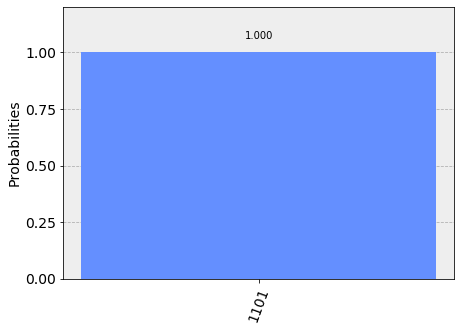

In [9]:
plot_histogram([resSim.get_counts(0)])

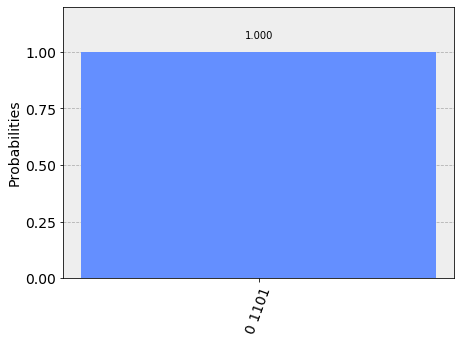

In [10]:
plot_histogram([resSim.get_counts(1)])

In [11]:
shots = 8192
#execute the job on real device
job = execute(transQcList, backend=device, shots=shots)
job_monitor(job)
#the results are stored in res.get_counts(0) to res.get_counts(99)
res = job.result()

Job Status: job has successfully run


Success rate of DJ algorithm without classical assertion:

In [13]:
calcSuccessrate(res.get_counts(0), ["1101"], 0)

total_count =  8192 success_count =  982 success_rate =  11.9873046875 %


Success rate of DJ algorithm with classical assertion:

In [15]:
calcSuccessrate(res.get_counts(1), ["0 1101"], 1)

total_count =  5223 success_count =  751 success_rate =  14.378709553896229 %
